In [5]:
import requests
from bs4 import BeautifulSoup
import pdftotext
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
def getPapersForYear(year):
    '''
        Input: year of Proceedings to scrape
        Output: A list of papers, each has the format {"title":, "paper_link":, "supplemental_link":}
    '''
    # Get Links to All Paper Abstracts 
    root_urls = {\
                "2020": "http://proceedings.mlr.press/v119/",\
                "2019": "http://proceedings.mlr.press/v97/",\
                "2018": "http://proceedings.mlr.press/v80/",\
                "2017": "http://proceedings.mlr.press/v70",\
                "2016": "http://proceedings.mlr.press/v48",\
                "2015": "http://proceedings.mlr.press/v37/",\
                "2014": "http://proceedings.mlr.press/v32/",\
                "2013": "http://proceedings.mlr.press/v28/"}
    root_url = root_urls[str(year)]
    resp = requests.get(root_url)
    
    mainPage_html = BeautifulSoup(resp.content, 'html.parser')
    paper_divs = mainPage_html.find_all('div', "paper")

    papers = []
    for paper_div in paper_divs:
        title = "Initial Title"
        try:
            title = paper_div.find("p", "title").text
            assert title != "Initial Title"
            
            paper_title_links = {"title": title, "year": year}
            links_a = paper_div.find("p", "links").find_all("a")
            for link in links_a: 
                if link.text == "Download PDF":
                    paper_title_links["paper_link"] = link['href']
                elif link.text == "Supplementary PDF":
                    paper_title_links["supplemental_link"] = link['href']
            assert len(paper_title_links) > 1
            papers.append(paper_title_links)
        except:
            print(title)
            continue
    with open("pickles/icml_papers_" + str(year) + ".pickle", "wb") as pickleFile:
        description = "list of paper metadata from ICML. Each entry is a dictionary containing\
        the paper title, link to paper pdf (if it exists), and link to supplemental materials (if it exists)"
        pickle.dump((description, papers), pickleFile)
    
    return papers

In [26]:
# Within Each Abstract, Download the paper and supplemental materials
def extractTextFromURL(paper):
    pdftxt = ""
    try:
        if "paper_link" in paper:
            #Download PDF
            with open('papers/' + paper["title"] + ".pdf", "wb") as pdfFile:
                rsp = requests.get(paper["paper_link"])
                pdfFile.write(rsp.content)

            #Extract Text
            with open('papers/' + paper["title"] + ".pdf", "rb") as pdfFile:
                pdf = pdftotext.PDF(pdfFile)
                pdftxt += "\n\n".join(pdf)

            #Delete PDF
            os.remove('papers/' + paper["title"] + ".pdf")

        if "supplemental_link" in paper:
            #Download PDF
            with open('supplemental/' + paper["title"] + ".pdf", "wb") as pdfFile:
                rsp = requests.get(paper["supplemental_link"])
                pdfFile.write(rsp.content)

            #Extract Text
            with open('supplemental/' + paper["title"] + ".pdf", "rb") as pdfFile:
                pdf = pdftotext.PDF(pdfFile)
                pdftxt += "\n\n".join(pdf)

            #Delete PDF
            os.remove('supplemental/' + paper["title"] + ".pdf")
    except:
        print("Could not extract text for: " + paper["title"])
    return pdftxt.lower()

In [27]:
def saveBroaderImpact(paper, txt):
    broader_impact_idx = txt.find("broader impact")
    if broader_impact_idx < 0:
        broader_impact_idx = txt.find("broader societal impact")
    if broader_impact_idx < 0:
        print("Could not find Broader Impact section for: " + paper["title"])
        return 
    
    txt = txt[broader_impact_idx:]
    end_idx = len(txt)
    acknowledgement_idx = txt.find("acknowledgement")
    references_idx = txt.find("references")
    if acknowledgement_idx > 0 and references_idx > 0:
        end_idx = min(acknowledgement_idx, references_idx)
    elif acknowledgement_idx > 0:
        end_idx = acknowledgement_idx
    elif references_idx > 0:
        end_idx = references_idx
    
    txt = txt[:end_idx]
    
    with open("papers/" + paper["title"] + ".txt", "w") as txtFile:
        txtFile.write(txt)

In [28]:
def parsePaper(paper, pdftxt, parsed_papers):
    keywords = [\
               ("Github", "github.com"),\
               ("GPU", "gpu"),\
               ("Reproducibility", "reproducibility"),\
               ("Broader Impact", "broader impact")]

    parsed_paper = {"title": paper["title"], "year": paper["year"]}
    for key, value in keywords:
        parsed_paper[key] = int(value in pdftxt)
    parsed_papers.append(parsed_paper)

In [23]:
papers = getPapersForYear(2020)
print(len(papers))

1084


In [38]:
years = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
parsed_papers = []
for year in years:
    print(str(year))
    papers = getPapersForYear(year)
    print("Finished getting links")
    for paper in papers:
        pdftxt = extractTextFromURL(paper)
        #saveBroaderImpact(paper, pdftxt)
        parsePaper(paper, pdftxt, parsed_papers)
    
    parsed_papers_pd = pd.DataFrame(parsed_papers)
    with open("pickles/icml_parsed_papers_pd.pickle", "wb") as pickleFile:
        description = "table with statistics of interest for ICML papers. Each paper is a row in which\
        we indicate the desired properties that are satisfied."
        pickle.dump((description, parsed_papers_pd), pickleFile)

2020
Finished getting links
2019
Finished getting links
Could not extract text for: First-Order Algorithms Converge Faster than $O(1/k)$ on Convex Problems
2018
Finished getting links
Could not extract text for: Fast Stochastic AUC Maximization with $O(1/n)$-Convergence Rate
Could not extract text for: Beyond 1/2-Approximation for Submodular Maximization on Massive Data Streams
Could not extract text for: Local Convergence Properties of SAGA/Prox-SVRG and Acceleration
2017
Finished getting links
Could not extract text for: Deep Voice: Real-time Neural Text-to-Speech
Could not extract text for: RobustFill: Neural Program Learning under Noisy I/O
2016
Finished getting links
Could not extract text for: A Subspace Learning Approach for High Dimensional Matrix Decomposition with Efficient Column/Row Sampling
2015
Finished getting links
2014
Finished getting links
2013
Finished getting links


In [43]:
parsed_papers_pd = pd.DataFrame(parsed_papers)
with open("pickles/icml_parsed_papers_pd.pickle", "wb") as pickleFile:
    description = "table with statistics of interest for neurips 2002 papers. Each paper is a row in which\
    we indicate the desired properties that are satisfied."
    pickle.dump((description, parsed_papers_pd), pickleFile)

In [44]:
with open("pickles/icml_parsed_papers_pd.pickle", "rb") as pickleFile:
    description, parsed_papers_pd = pickle.load(pickleFile)

parsed_papers_pd.groupby("year").mean()

,Github,GPU,Reproducibility,Broader Impact
year,,,,
2013,0.035336,0.049470,0.003534,0.000000
2014,0.054839,0.054839,0.003226,0.000000
2015,0.144444,0.096296,0.007407,0.000000
2016,0.180124,0.136646,0.018634,0.000000
2017,0.237327,0.158986,0.009217,0.000000
2018,0.346216,0.190016,0.017713,0.000000
2019,0.438551,0.192755,0.032342,0.002587
2020,0.486162,0.279520,0.054428,0.000923


Text(0.5, 1.0, 'Fraction of ICML papers containing computing keywords (2011-2020)')

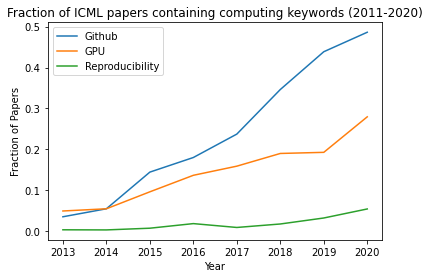

In [45]:
ax = plt.subplot()
parsed_papers_pd[["year", "Github", "GPU", "Reproducibility"]].groupby("year").mean().plot(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Fraction of Papers")
ax.set_title("Fraction of ICML papers containing computing keywords (2011-2020)")

0                              Compositional Plan Vectors
1           Learning to Propagate for Graph Meta-Learning
2       XNAS: Neural Architecture Search with Expert A...
3          Multi-resolution Multi-task Gaussian Processes
4                                 Deep Equilibrium Models
                              ...                        
7426                Pylon Model for Semantic Segmentation
7427               How biased are maximum entropy models?
7428         Gaussian process modulated renewal processes
7429    An ideal observer model for identifying the re...
7430    Greedy Algorithms for Structurally Constrained...
Name: title, Length: 7431, dtype: object